<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<style>
    h1 {
        line-height: 200%;
        font-family: 'Comic Sans MS', cursive, sans-serif;
        color: #ffb6c1; /* رنگ نارنجی پاستیلی */
    }
</style>
</head>
<body>
    <h1>Zahra Alinaghipour</h1>
</body>
</html>

Recommender Systems

Using a deep learning architecture, we implemented a model that can estimate a user's interest in a specific item. With this model, we can generate a list of items to recommend to the user that they have not purchased yet, but according to the patterns the model has found between users and items, they are likely to enjoy and rate highly. The dataset for this project includes real data related to electronic products available on the online store <a href="https://Amazon.com/" target="_blank">Amazon</a>.

Although this project deals with online store data, this recommender model can be applied to various domains. For example, a similar system can be designed to recommend movies or music tracks to users.

The training data is located in the file amazon_train.csv. This file contains 4 columns, which respectively represent the user ID, product ID, the rating given by the user to the product, and the timestamp of the rating. The network I implemented takes the numerical IDs of the user and the product as input and predicts the rating that the user would give to that product.

In [2]:
import numpy as np
import pandas as pd

train = pd.read_csv('./data/amazon_train.csv')
valid = pd.read_csv('./data/amazon_valid.csv')
test = pd.read_csv('./data/amazon_test.csv')

In [3]:
train.head()

,UserID,ProductID,Rating,Timestamp
0,A3HICVLF4PFFMN,0594481813,5.0,2014-05-05
1,A2QBZA4S1ROX9Q,0594481813,3.0,2013-05-25
2,AT09WGFUM934H,0594481813,3.0,2013-08-31
3,AGAKHE014LQFU,0594481813,3.0,2013-09-18
4,A1S6B5QFWGVL5U,0594481813,4.0,2013-06-27


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909201 entries, 0 to 909200
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   UserID     909201 non-null  object 
 1   ProductID  909201 non-null  object 
 2   Rating     909201 non-null  float64
 3   Timestamp  909201 non-null  object 
dtypes: float64(1), object(3)
memory usage: 27.7+ MB


In [5]:
train['Rating'].value_counts(normalize=True)

Rating
5.0    0.598494
4.0    0.212489
3.0    0.084920
1.0    0.057540
2.0    0.046558
Name: proportion, dtype: float64

In [6]:
valid['Rating'].value_counts(normalize=True)

Rating
5.0    0.613808
4.0    0.196499
3.0    0.083675
1.0    0.059353
2.0    0.046664
Name: proportion, dtype: float64

In [7]:
from imblearn.over_sampling import RandomOverSampler

sampling_strategy = {1: round(train['Rating'].value_counts()[1]*2.5),
                     2: round(train['Rating'].value_counts()[2]*3),
                     3: round(train['Rating'].value_counts()[3]*2)}

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(train[['UserID', 'ProductID']], train['Rating'])

train_ros = pd.DataFrame(X_train_ros, columns=['UserID', 'ProductID'])
train_ros['Rating'] = y_train_ros

train_ros.head()

,UserID,ProductID,Rating
0,A3HICVLF4PFFMN,0594481813,5.0
1,A2QBZA4S1ROX9Q,0594481813,3.0
2,AT09WGFUM934H,0594481813,3.0
3,AGAKHE014LQFU,0594481813,3.0
4,A1S6B5QFWGVL5U,0594481813,4.0


In [8]:
train_ros['Rating'].value_counts(normalize=True)

Rating
5.0    0.473362
4.0    0.168062
3.0    0.134330
1.0    0.113774
2.0    0.110472
Name: proportion, dtype: float64

In [9]:
train = train_ros

In [10]:
from sklearn.preprocessing import LabelEncoder

le_user = LabelEncoder()
train['UserEnc'] = le_user.fit_transform(train['UserID'].values)

le_product = LabelEncoder()
train['ProductEnc'] = le_product.fit_transform(train['ProductID'].values)

In [11]:
train.head()

,UserID,ProductID,Rating,UserEnc,ProductEnc
0,A3HICVLF4PFFMN,0594481813,5.0,59277,0
1,A2QBZA4S1ROX9Q,0594481813,3.0,41167,0
2,AT09WGFUM934H,0594481813,3.0,85549,0
3,AGAKHE014LQFU,0594481813,3.0,77047,0
4,A1S6B5QFWGVL5U,0594481813,4.0,18672,0


In [12]:
valid['UserEnc'] = le_user.transform(valid['UserID'].values)
valid['ProductEnc'] = le_product.transform(valid['ProductID'].values)

test['UserEnc'] = le_user.transform(test['UserID'].values)
test['ProductEnc'] = le_product.transform(test['ProductID'].values)

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the Rating column
scaler = MinMaxScaler()
train['RatingNorm'] = scaler.fit_transform(np.array(train['Rating']).reshape(-1, 1))

train.head()

,UserID,ProductID,Rating,UserEnc,ProductEnc,RatingNorm
0,A3HICVLF4PFFMN,0594481813,5.0,59277,0,1.00
1,A2QBZA4S1ROX9Q,0594481813,3.0,41167,0,0.50
2,AT09WGFUM934H,0594481813,3.0,85549,0,0.50
3,AGAKHE014LQFU,0594481813,3.0,77047,0,0.50
4,A1S6B5QFWGVL5U,0594481813,4.0,18672,0,0.75


In [14]:
valid['RatingNorm'] = scaler.transform(np.array(valid['Rating']).reshape(-1, 1))

In [15]:
import keras
# Building the model

N_USERS = train['UserEnc'].nunique()
N_ITEMS = train['ProductEnc'].nunique()
EMBEDDING_SIZE = 200


# User
input_user = keras.layers.Input(shape = (1,),
                                dtype = 'int64',
                                name = 'input_user')

embedding_user = keras.layers.Embedding(N_USERS, EMBEDDING_SIZE,
                                        embeddings_initializer = 'he_normal',
                                        name = 'embedding_user')(input_user)

embedding_user = keras.layers.Flatten()(embedding_user)

embedding_user_bias = keras.layers.Embedding(N_USERS, 1,
                                        embeddings_initializer = 'he_normal',
                                        name = 'embedding_user_bias')(input_user)

embedding_user_bias = keras.layers.Flatten()(embedding_user_bias)

# Product
input_product = keras.layers.Input(shape = (1,),
                                dtype = 'int64',
                                name = 'input_product')

embedding_product = keras.layers.Embedding(N_ITEMS, EMBEDDING_SIZE,
                                        embeddings_initializer = 'he_normal',
                                        name = 'embedding_product')(input_product)

embedding_product = keras.layers.Flatten()(embedding_product)

embedding_product_bias = keras.layers.Embedding(N_ITEMS, 1,
                                        embeddings_initializer = 'he_normal',
                                        name = 'embedding_product_bias')(input_product)

embedding_product_bias = keras.layers.Flatten()(embedding_product_bias)

# User-Product Interaction and Output
interaction = keras.layers.dot([embedding_user, embedding_product], axes = 1)
interaction = keras.layers.add([interaction, embedding_user_bias, embedding_product_bias])
output = keras.layers.Activation('sigmoid')(interaction)

# Final model
model = keras.models.Model([input_user, input_product], output)

In [16]:
# Training phase
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='binary_crossentropy')

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_user (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 input_product (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_user (Embedding)  (None, 1, 200)               1801000   ['input_user[0][0]']          
                                                          0                                       
                                                                                                  
 embedding_product (Embeddi  (None, 1, 200)               9753800   ['input_product[0][0]']   

In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)

In [19]:
history = model.fit([train['UserEnc'], train['ProductEnc']], train['RatingNorm'],
                    batch_size=64, epochs=7, callbacks=[checkpoint_cb],
                    validation_data=([valid['UserEnc'], valid['ProductEnc']], valid['RatingNorm']))

Epoch 1/7
17962/17962 [==============================] - 176s 10ms/step - loss: 0.5842 - val_loss: 0.5225
Epoch 2/7
17962/17962 [==============================] - 172s 10ms/step - loss: 0.3505 - val_loss: 0.4833
Epoch 3/7
17962/17962 [==============================] - 169s 9ms/step - loss: 0.2900 - val_loss: 0.4836
Epoch 4/7
17962/17962 [==============================] - 170s 9ms/step - loss: 0.2847 - val_loss: 0.4893
Epoch 5/7
17962/17962 [==============================] - 170s 9ms/step - loss: 0.2845 - val_loss: 0.4942
Epoch 6/7
17962/17962 [==============================] - 171s 10ms/step - loss: 0.2832 - val_loss: 0.4986
Epoch 7/7
17962/17962 [==============================] - 170s 9ms/step - loss: 0.2836 - val_loss: 0.5018


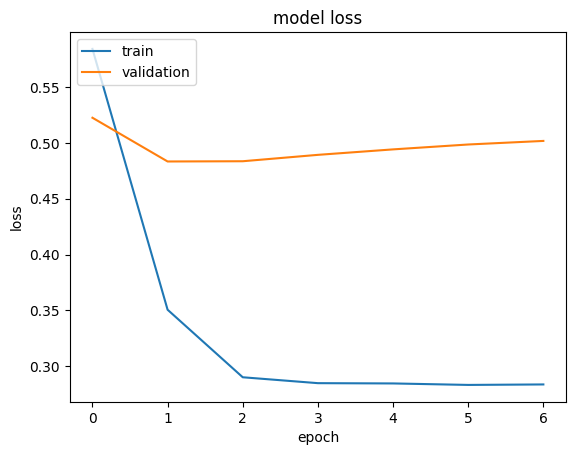

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [21]:
model = keras.models.load_model("model.keras")

In [22]:
# Evaluate on validation data
from sklearn.metrics import precision_score

predictions = model.predict([valid['UserEnc'], valid['ProductEnc']])
predictions = scaler.inverse_transform(predictions)
predictions = np.round(predictions)
predictions[predictions < 4] = 0
predictions[predictions >= 4] = 1

true_rating = valid['Rating'].values.copy()
true_rating[true_rating < 4] = 0
true_rating[true_rating >= 4] = 1

result = precision_score(true_rating, predictions) * 100
print(result)

2810/2810 [==============================] - 5s 2ms/step
85.09355752109057


In [23]:
predictions = model.predict([test['UserEnc'], test['ProductEnc']])
predictions = scaler.inverse_transform(predictions)
predictions = np.round(predictions)

2805/2805 [==============================] - 4s 2ms/step


In [24]:
# Preparing submission file
submission = test.copy()
submission['Rating'] = predictions
submission = submission[['UserID', 'ProductID', 'Rating']]
submission

,UserID,ProductID,Rating
0,A2Y3A341VDK37H,B00HFI55N2,3.0
1,A240FRPD4MEXND,B00KIMX4EY,4.0
2,A3SBTW3WS4IQSN,B001IF252M,4.0
3,A1QCZQTJNK3MU,B00J46VVKE,4.0
4,A16JT7E5121OAB,B00JZC972Q,3.0
...,...,...,...
89727,A37Z65SZVT0TVB,B00005AR4L,4.0
89728,A3PLX6PTM2ERKL,B00004Z6PI,5.0
89729,A3TRPVAGT3NWBS,B00005NVPW,4.0
89730,AY8Q1X7G96HV5,B000059MSI,4.0
